# 1.5 上位を目指すためのポイント

Titanicを例に進める。

https://www.kaggle.com/c/titanic/overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('../input/ch01/train.csv')
test = pd.read_csv('../input/ch01/test.csv')

In [3]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [5]:
train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']

test_x = test.copy()

## EDA(Exploratory Data Analysis)

・変数別の統計量、欠損値、外れ値、及び変数間の相関係数の確認。

・データの可視化。

In [6]:
train_x.drop(['PassengerId'], axis=1).describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
test_x.drop(['PassengerId'], axis=1).describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [8]:
print('Train data length: ', len(train_x))
print('\nTest data length: ', len(test_x))
print('\nNum of missing values in train data:')
print(train_x.isnull().sum())
print('\nNum of missing values in test data:')
print(test_x.isnull().sum())

Train data length:  891

Test data length:  418

Num of missing values in train data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Num of missing values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [9]:
# train_xとtest_xの相関係数（ピアソン）の算出
# https://www.koka.ac.jp/morigiwa/sjs/les10801.htm

train_x.drop('PassengerId', axis=1).corrwith(test_x.drop('PassengerId', axis=1))

Pclass    0.021804
Age       0.029737
SibSp    -0.010949
Parch    -0.015740
Fare     -0.045061
dtype: float64

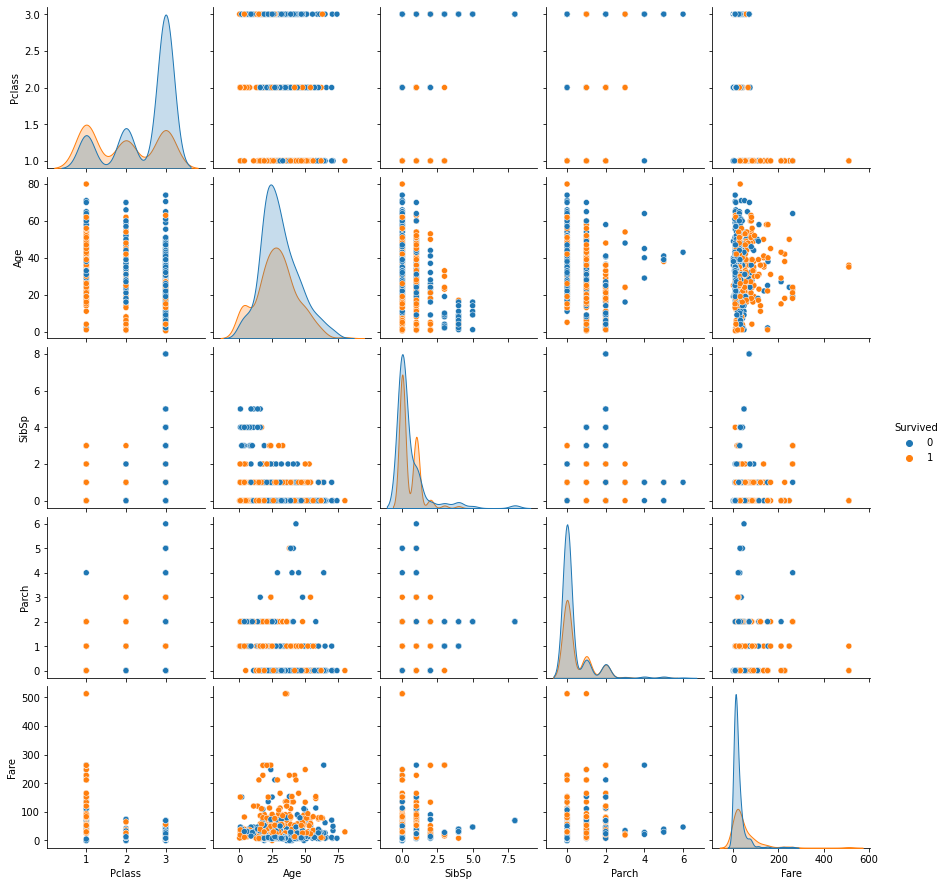

In [10]:
sns.pairplot(train.drop('PassengerId', axis=1), hue='Survived')

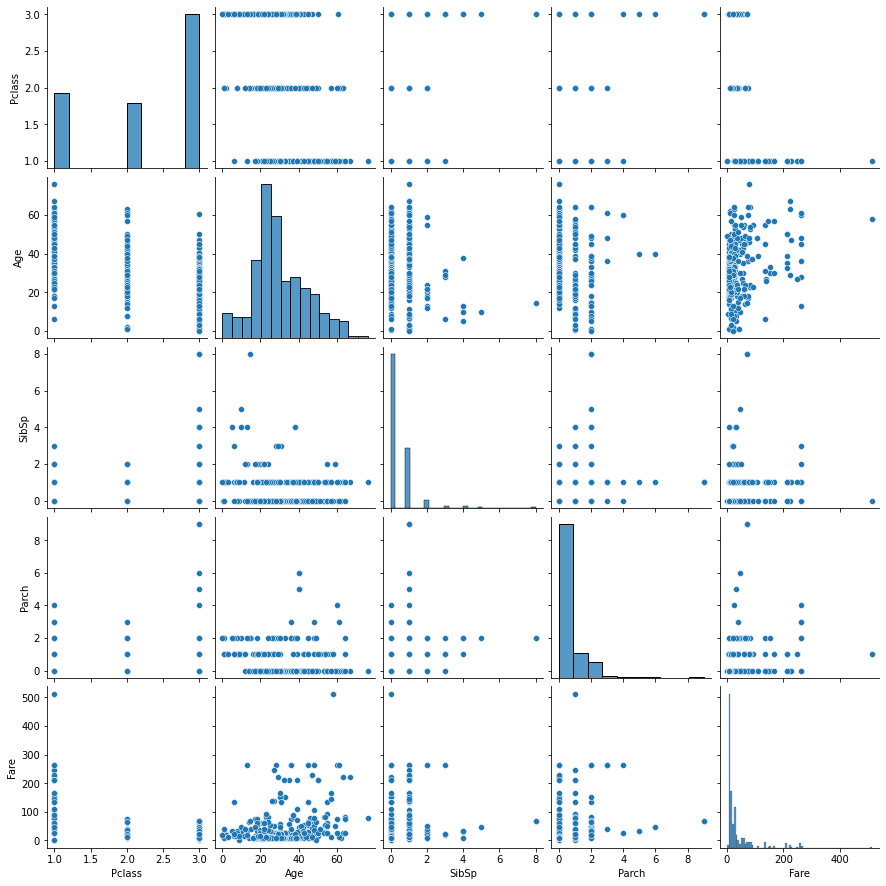

In [11]:
sns.pairplot(test.drop('PassengerId', axis=1))

## 特徴量の作成

GBDTに学習させるデータセットの構築。

・必要なかったり、扱いが簡単ではない変数を一旦削除。

・文字列の値が格納されている変数をエンコーディング。

・GBDTなので欠損値はそのまま。（補完も1つの方法）

これらの簡単な前処理を行い、データセット構築。

In [12]:
from sklearn.preprocessing import LabelEncoder

train_x = train_x.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_x = test_x.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# ラベルエンコーディング適用
for c in ['Sex', 'Embarked']:
    le = LabelEncoder()
    le.fit(train_x[c].fillna('NA'))
    
    train_x[c] = le.transform(train_x[c].fillna('NA'))
    test_x[c] = le.transform(test_x[c].fillna('NA'))

## モデルの作成

In [13]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(train_x, train_y)

# predict_proba: 予測値を確率で出力
pred = model.predict_proba(test_x)[:, 1]

# 二値に変換
pred_label = np.where(pred > 0.5, 1, 0)

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred_label})

#submission.to_csv('submission_first.csv', index=False)

In [14]:
# !kaggle competitions submit -c titanic -f submission_first.csv -m "First submit"
# Public leaderboard score: 0.76555

## モデルの評価

・CrossValidationを用いて、モデルの評価を行う。

・accuracyは小さな変化を捉えづらいので、評価指標にはloglossを選択。

In [15]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold

scores_logloss = []
scores_accuracy = []

# データを4分割し、内1つをバリデーションに用いる流れを4回繰り返す
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for tr_idx, va_idx in kf.split(train_x):
    # データを分割
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    model = XGBClassifier(n_estimators=20, random_state=42)
    model.fit(tr_x, tr_y)
    
    # バリデーションの予測値を出力、fold別のスコア算出
    va_pred = model.predict_proba(va_x)[:, 1]
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)
    
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)
    
# 各foldを平均し、スコア算出
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)
print(f'logloss: {logloss: .4f}, accuracy: {accuracy: .4f}')

logloss:  0.4350, accuracy:  0.8238


## モデルのチューニング

・グリッドサーチ（チューニング対象の候補を全探索）を使用し、パラメータチューニング。

In [16]:
import itertools

# チューニング対象の候補
param_space = {
    'max_depth': [3,5,7],
    'min_child_weight': [1.0,2.0,4.0]
}
# 探索するハイパーパラメータの組み合わせ
param_conbinations = itertools.product(param_space['max_depth'], param_space['min_child_weight'])

params = []
scores = []

# 各パラメータの組み合わせごとに、CrossValidationでの評価を行う
for max_depth, min_child_weight in param_conbinations:
    
    score_folds = []
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    for tr_idx, va_idx in kf.split(train_x):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model = XGBClassifier(n_estimators=20, random_state=42,
                              max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)
        
        va_pred = model.predict_proba(va_x)[:, 1]
        logloss = log_loss(va_y, va_pred)
        score_folds.append(logloss)
        
    score_mean = np.mean(score_folds)
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)

# ハイパーパラメータそれぞれのベストを取り出し、表示
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}')

max_depth: 3, min_child_weight: 2.0


## アンサンブル

ロジスティック回帰モデルとの加重平均によるアンサンブルを試みる。

In [17]:
# GBDT以外の機械学習アルゴリズムに学習させるデータは欠損値を補完するのが一般的。平均値で補完してみる。
train_x2 = train_x.fillna(train_x.mean())
test_x2 = test_x.fillna(test_x.mean())

In [18]:
from sklearn.linear_model import LogisticRegression

model_xgb =  XGBClassifier(n_estimators=20, 
                           random_state=42, 
                           max_depth=best_param[0], 
                           min_child_weight=best_param[1])
model_xgb.fit(train_x, train_y)
pred_xgb = model_xgb.predict_proba(test_x)[:, 1]

model_lr = LogisticRegression(solver='lbfgs', 
                              max_iter=300,
                              random_state=42)
model_lr.fit(train_x2, train_y)
pred_lr = model_lr.predict_proba(test_x2)[:, 1]

# 加重平均
pred = pred_xgb * 0.8 + pred_lr * 0.2
pred_label = np.where(pred > 0.5, 1, 0)

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred_label})
#submission.to_csv('submission_second.csv', index=False)

In [19]:
# !kaggle competitions submit -c titanic -f submission_second.csv -m "Second submit"
# Public leaderboard score: 0.77751